In [1]:
import numpy as truenp

import matplotlib.pyplot as plt
import matplotlib.cm as color
better_magma = color.magma
better_magma.set_bad('black',1.)
import matplotlib.colors as c

from prysm import (
    mathops, 
    conf,
)
from prysm.mathops import (
    np,
    fft,
    interpolate,
    ndimage,
)
from prysm.coordinates import (
    make_xy_grid, 
    cart_to_polar,
)
from prysm.propagation import Wavefront as WF
from prysm.propagation import (
    focus_fixed_sampling,
    focus_fixed_sampling_backprop
)                              
from prysm.thinlens import (
    defocus_to_image_displacement,
    image_displacement_to_defocus,
)
from prysm.geometry import (
    circle,
    spider,
)
from prysm.polynomials import (
    lstsq,
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes,
    sum_of_2d_modes_backprop
)
mathops.set_backend_to_cupy()
# conf.config.precision = 32

from astropy.io import (
    fits,
    ascii,
)

from skimage.measure import centroid

from lina.phase_retrieval import ADPR, FDPR, BBPR
from lina.utils import TikhonovInverse

import config_um
import config_um_wcc
from Batoid4LOFT.LAZULI_STOP import Lazuli_stop, readBulkMotion, readDeformation

from psd_utils import PSDUtils

from scipy.optimize import minimize

from scipy.interpolate import RegularGridInterpolator

from tqdm import tqdm

from psd_utils import PSDUtils

from model import off_axis_3m_TMA
from algos import FFPR
import utils

# logging stuff
import logging
psd_log = logging.getLogger('__psd_utils__')
psd_log.disabled = True

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
cfg_um = config_um.load_config_values('unitless')
cfg_um_wcc = config_um_wcc.load_config_values('unitless')

path_um = config_um.get_data_path()
path_um_wcc = config_um_wcc.get_data_path() + '/'

In [3]:
opd_maps = utils.load_pickle('/home/derbyk/src/ffpr/data/opd_maps.pkl')

In [4]:
sys = off_axis_3m_TMA(opd_maps=opd_maps, config_stp=cfg_um, config_wcc=cfg_um_wcc,
                      data_path_stp=path_um, data_path_wcc=path_um_wcc)

# lots n lots o stars
mags = (np.ones(9) * 17).tolist()
positions = [(-8,  4), (0,  4), (8,  4),
             (-8,  0), (0,  0), (8,  0),
             (-8, -4), (0, -4), (8, -4),]
defocuses = [0.5, -0.5,  1,
              -1,   0,   -1,
              1,  -0.5, 0.5]
sys.set_source_parameters(magnitudes=mags, positions=positions, defocus_vals=defocuses)

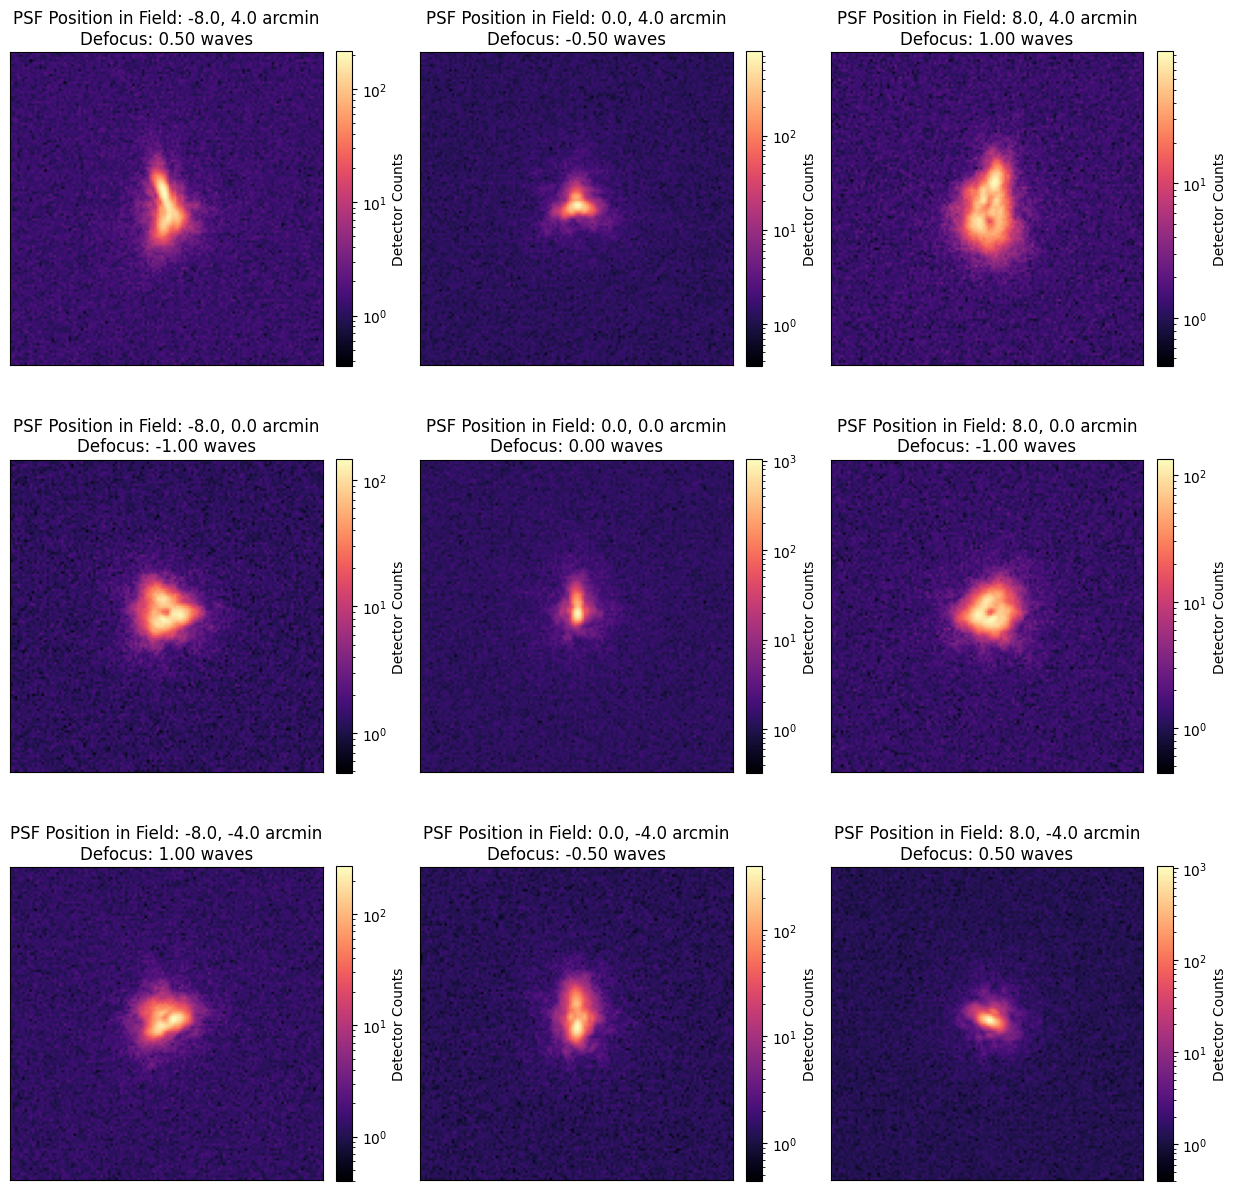

In [5]:
images = sys.snap(stacked_frames=25)

plt.figure(figsize=(15, 15))
for i, image in enumerate(images):
    plt.subplot(3, 3, i + 1)
    plt.title(f'PSF Position in Field: {sys.src_pos[i][0] * 60:.01f}, {sys.src_pos[i][1] * 60:.01f} arcmin\nDefocus: {sys.defocus_vals[i] / 625:.02f} waves')
    plt.imshow(image.get(), cmap='magma', norm='log')
    plt.colorbar(fraction=0.046, pad=0.04, label='Detector Counts')
    plt.xticks([])
    plt.yticks([])

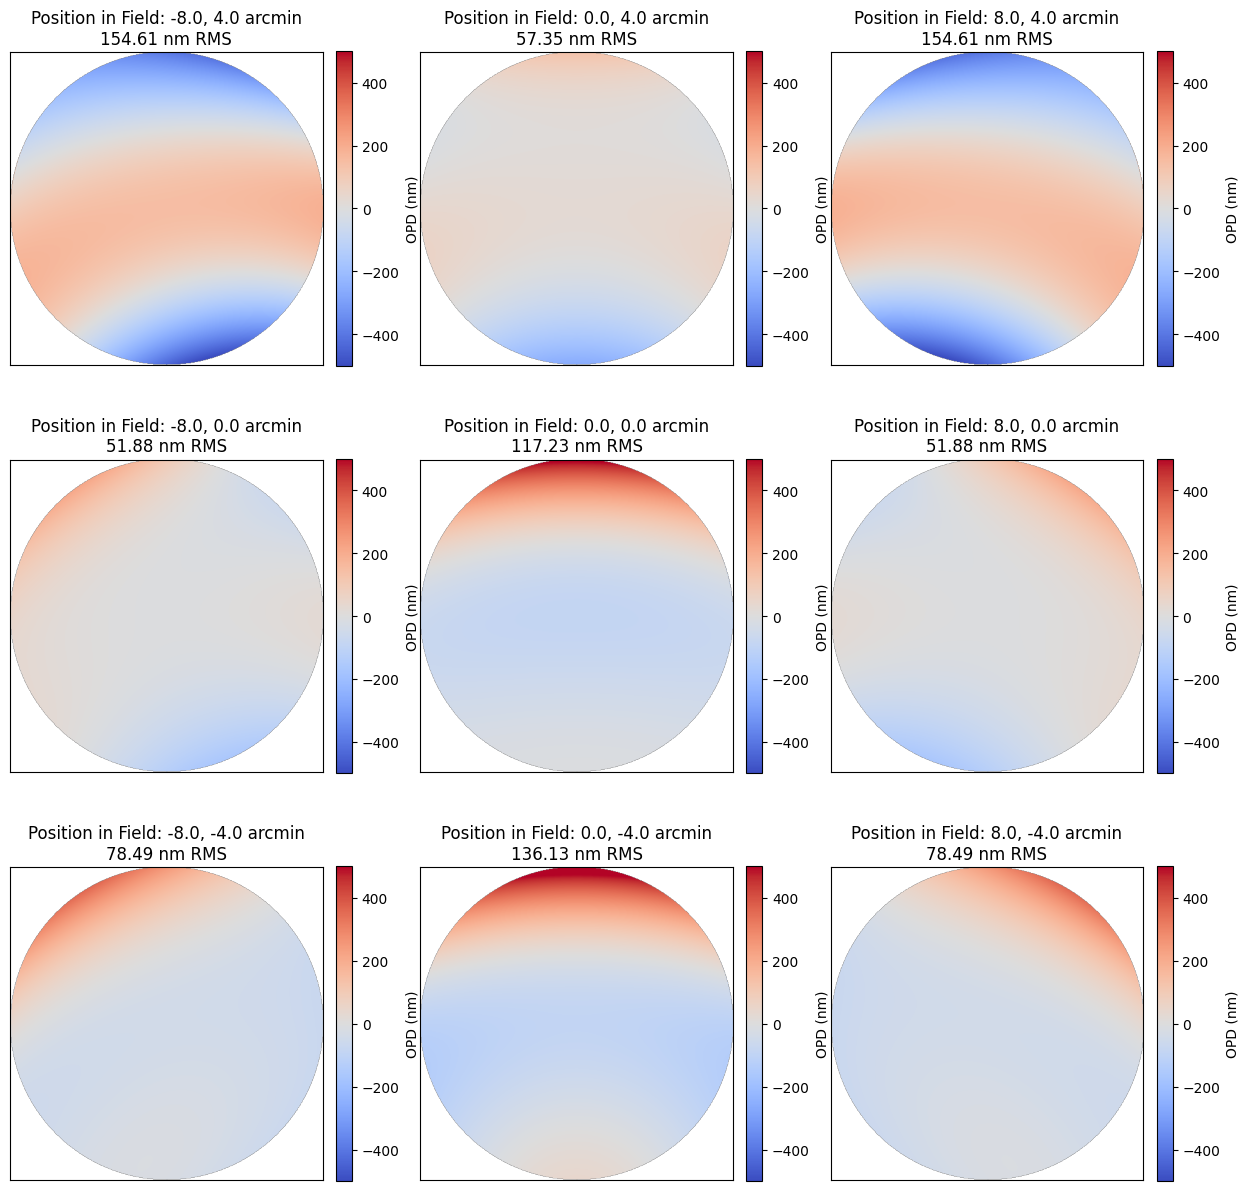

In [6]:
opds = sys.get_opds()

plt.figure(figsize=(15, 15))
for i, field_opd in enumerate(opds['Field']):
    field_opd[~sys.pupil] = np.nan
    field_opd -= np.nanmean(field_opd)
    rms = np.sqrt(np.nanmean(field_opd ** 2))

    plt.subplot(3, 3, i + 1)
    plt.title(f'Position in Field: {sys.src_pos[i][0] * 60:.01f}, {sys.src_pos[i][1] * 60:.01f} arcmin\n{rms:0.2f} nm RMS')
    plt.imshow(field_opd.get(), cmap='coolwarm', vmin=-500, vmax=500)
    plt.colorbar(fraction=0.046, pad=0.04, label='OPD (nm)')
    plt.xticks([])
    plt.yticks([])

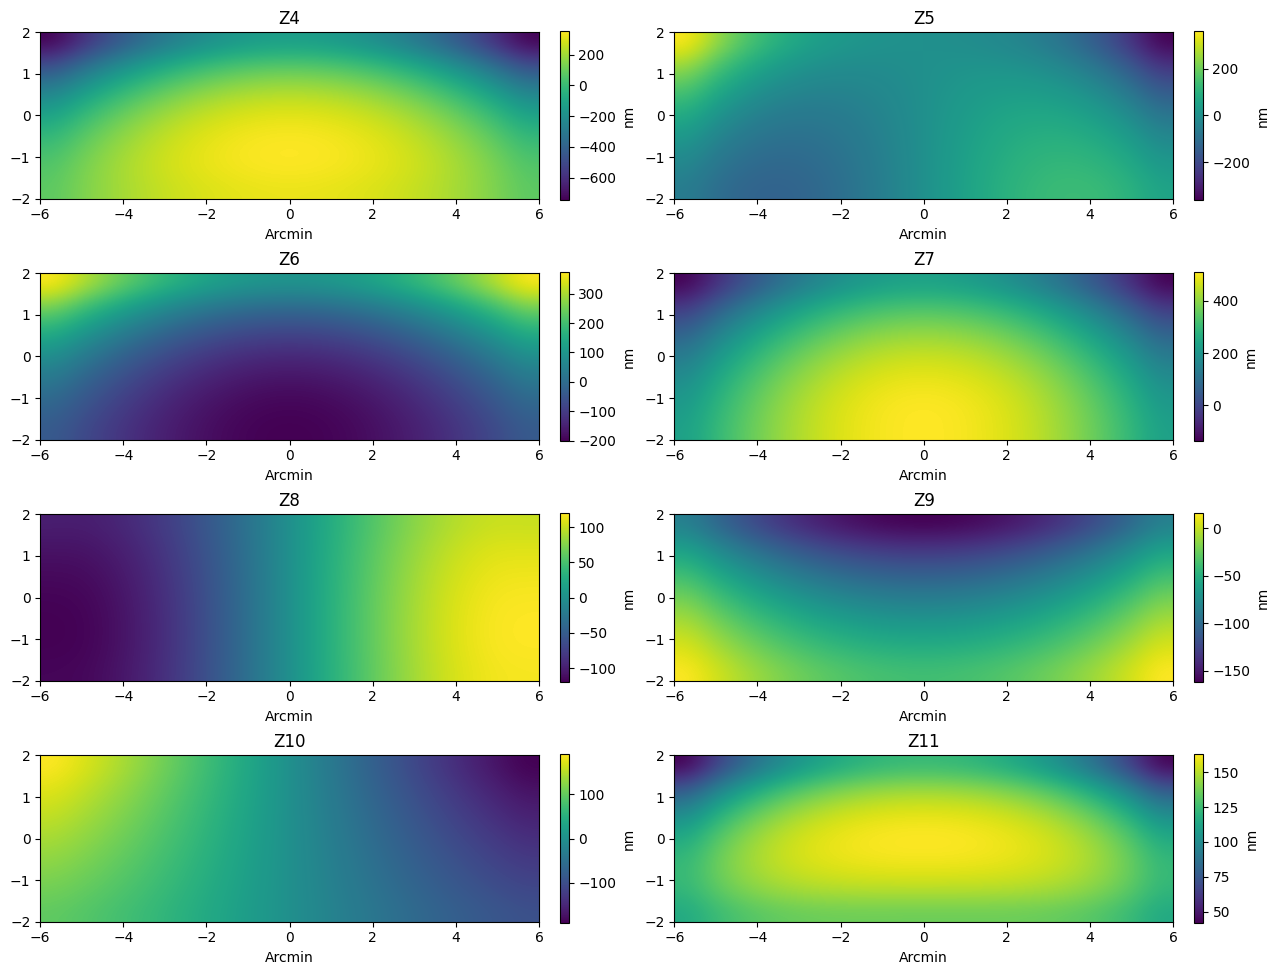

In [ ]:
raytrace = Lazuli_stop()

# zernike basis (excluding piston) up to Z37
x, y = make_xy_grid(sys.pupil.shape[0], dx=sys.dx_pup)
r, t = cart_to_polar(x, y)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, r, t, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernikes]

# indices for the zernikes which exhibit field dependence that changes with alignment: defocus, coma, astig, trefoil, spherical
# THESE DO NOT CORRESPOND TO NOLL INDICES
inds = [i + 2 for i in range(8)]

# field positions to evaluate
fields_x = np.linspace(-8.1, 8.1, 17) / 60 # +/- 16.2 arcmin in x
fields_y = np.linspace(-2.4, 2.4, 5) / 60  # +/- 4.8 arcmin in y

# initialize array to hold coeffs for field-dependent zernikes at nominal alignment
field_coeffs_nom = np.zeros((len(inds), len(fields_x), len(fields_y)))

# loop through fields
for i, field_x in enumerate(fields_x):
    for j, field_y in enumerate(fields_y):
        
        # get raytrace OPD at field point
        ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=sys.pupil.shape[0])
        opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
        opd[~sys.pupil] = np.nan

        # decompose
        field_coeffs_nom[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

# create interpolators for field-dependent zernikes
field_interps_nom = [interpolate.RegularGridInterpolator((fields_x, fields_y), field_coeffs_nom[i, :, :], method='cubic') for i in range(field_coeffs_nom.shape[0])]

# show field dependence for field-dependent zernikes
plt.figure(figsize=(15, 12))
for i in range(field_coeffs_nom.shape[0]):
    plt.subplot(4, 2, i + 1)
    plt.title(f'Z{i + 4:.0f}')
    plt.imshow(field_coeffs_nom[i, :, :].get().T, interpolation='bicubic', extent=[-8.1, 8.1, -2.4, 2.4])
    plt.xlabel('Arcmin')
    plt.colorbar(fraction=0.016, pad=0.04, label='nm')

In [ ]:
M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M2_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 1e-6, 'tip' : 0, 'tilt' : 0}}
M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

raytrace = Lazuli_stop(M1_dict=M1_motion, M2_dict=M2_motion, M3_dict=M3_motion, M4_dict=M4_motion)

field_coeffs_mis = np.zeros((len(inds), len(fields_x), len(fields_y)))

# loop through fields
for i, field_x in enumerate(fields_x):
    for j, field_y in enumerate(fields_y):
        
        # get raytrace OPD at field point
        ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=sys.pupil.shape[0])
        opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
        opd[~sys.pupil] = np.nan

        # decompose
        field_coeffs_mis[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

plt.figure(figsize=(15, 12))
for i in range(field_coeffs_mis.shape[0]):
    plt.subplot(4, 2, i + 1)
    plt.title(f'Z{i + 4:.0f}')
    plt.imshow(field_coeffs_mis[i, :, :].get().T - field_coeffs_nom[i, :, :].get().T, extent=[-6, 6, -2, 2])
    plt.xlabel('Arcmin')
    plt.colorbar(fraction=0.016, pad=0.04, label='nm')

NameError: name 'inds' is not defined

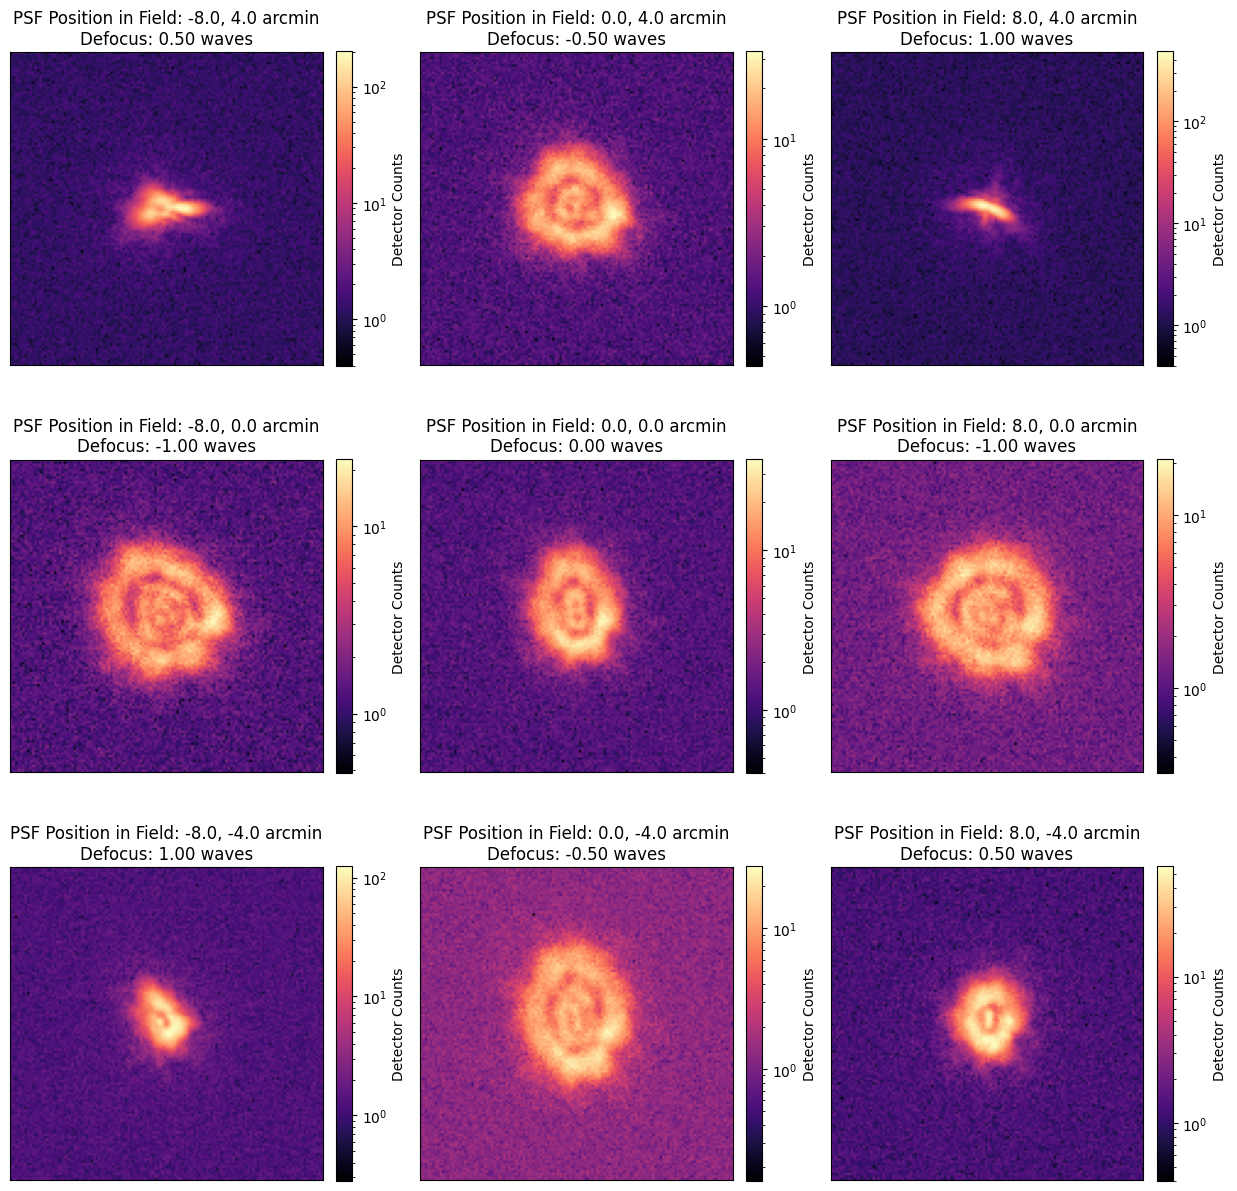

In [78]:
M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M2_motion = {'user_motion' : {'x' : 15e-6, 'y' : -5e-6, 'z' : -25e-6, 'tip' : truenp.deg2rad(-5 / 3600), 'tilt' : truenp.deg2rad(5 / 3600)}}
M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion, M3_motion=M3_motion, M4_motion=M4_motion)

images = sys.snap(stacked_frames=25)

plt.figure(figsize=(15, 15))
for i, image in enumerate(images):
    plt.subplot(3, 3, i + 1)
    plt.title(f'PSF Position in Field: {sys.src_pos[i][0] * 60:.01f}, {sys.src_pos[i][1] * 60:.01f} arcmin\nDefocus: {sys.defocus_vals[i] / 625:.02f} waves')
    plt.imshow(image.get(), cmap='magma', norm='log')
    plt.colorbar(fraction=0.046, pad=0.04, label='Detector Counts')
    plt.xticks([])
    plt.yticks([])

In [ ]:
adpr_list = []
for psf, defocus in zip(images, defocuses):
    adpr_list.append(ADPR(wvls=sys.wvls.tolist(), pupil=sys.pupil, dx_pupil=sys.dx_pup, psf=psf, dx_psf=sys.dx_detector,
                          efl=sys.efl, modes=zernikes, defocus_coeff=defocus))

ff_opt = FFPR(optlist=adpr_list, psf_positions=sys.src_pos, field_modes=zernikes[2:10], field_coeff_interps=field_interps_nom)

/tmp/ipykernel_1162581/1950115275.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


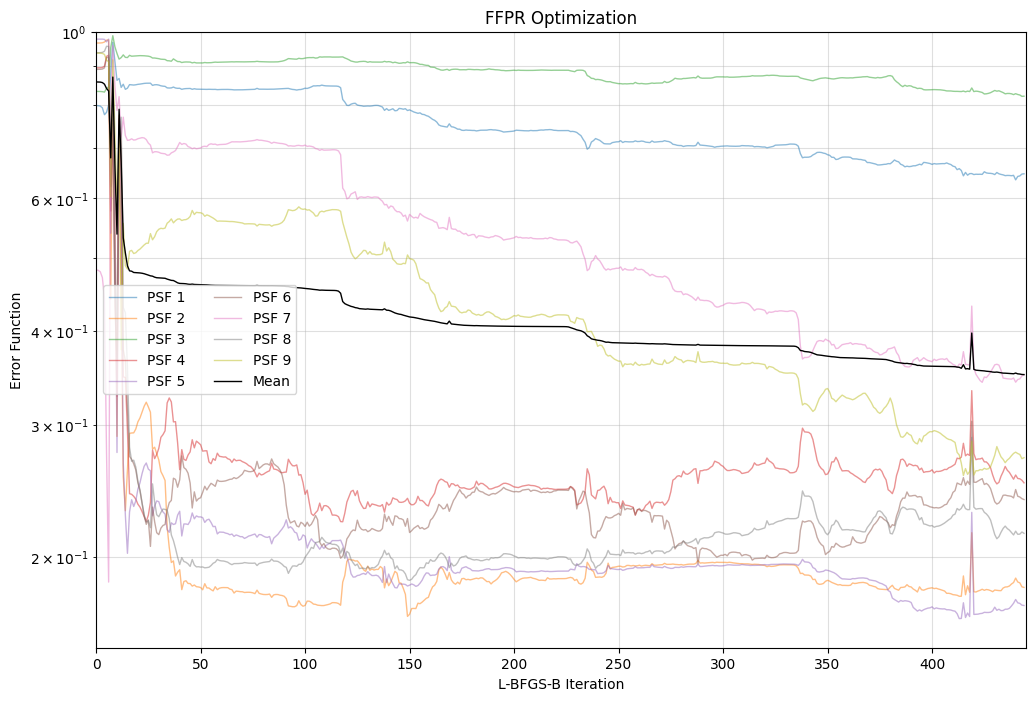

In [87]:
ff_opt.minimize_common(jac=True, method='L-BFGS-B', options={'maxls' : 20, 'ftol' : 1e-20, 'gtol' : 1e-6, 'disp' : 0, 'maxiter' : 100})

plt.figure(figsize=(12, 8))
plt.title('FFPR Optimization')
for i, opt in enumerate(ff_opt.optlist):
    plt.semilogy(np.array(opt.costs).get(), label=f'PSF {i + 1:.0f}', alpha=0.5, linewidth=1)
plt.semilogy(np.array(ff_opt.costs).get(), label='Mean', color='k', linewidth=1)
plt.xlabel('L-BFGS-B Iteration')
plt.ylabel('Error Function')
plt.legend(ncol=2)
plt.xlim([0, len(ff_opt.costs)])
plt.ylim([0, 1])
plt.grid(alpha=0.4, which='both')

/tmp/ipykernel_1162581/2687367122.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


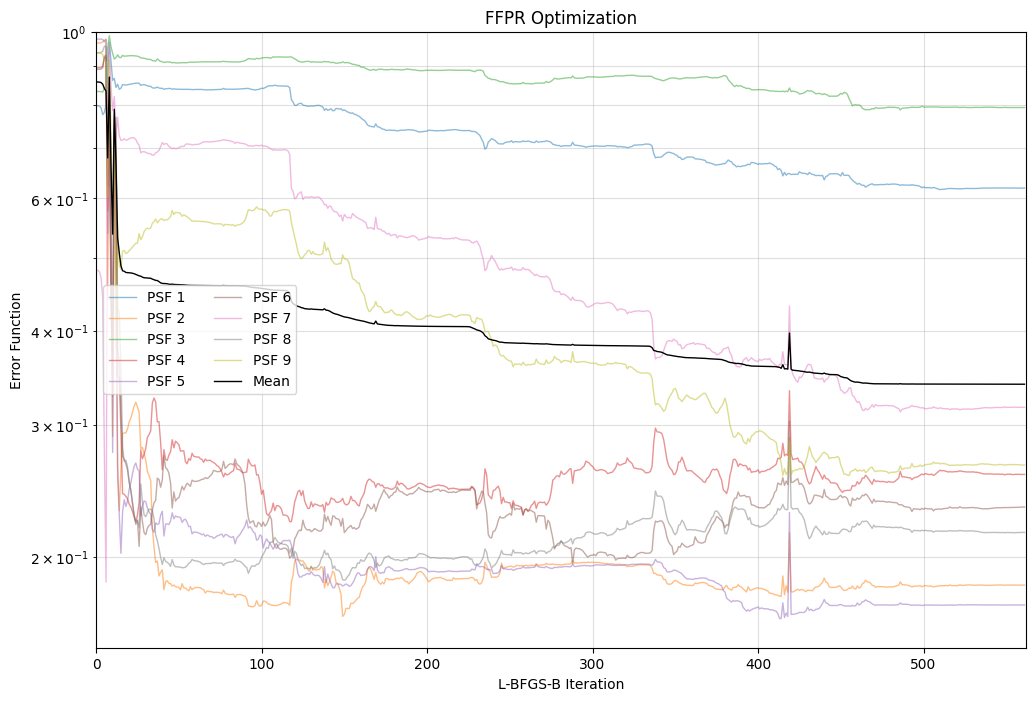

In [88]:
ff_opt.minimize_field(jac=True, method='L-BFGS-B', options={'maxls' : 20, 'ftol' : 1e-20, 'gtol' : 1e-8, 'disp' : 0, 'maxiter' : 100})

plt.figure(figsize=(12, 8))
plt.title('FFPR Optimization')
for i, opt in enumerate(ff_opt.optlist):
    plt.semilogy(np.array(opt.costs).get(), label=f'PSF {i + 1:.0f}', alpha=0.5, linewidth=1)
plt.semilogy(np.array(ff_opt.costs).get(), label='Mean', color='k', linewidth=1)
plt.xlabel('L-BFGS-B Iteration')
plt.ylabel('Error Function')
plt.legend(ncol=2)
plt.xlim([0, len(ff_opt.costs)])
plt.ylim([0, 1])
plt.grid(alpha=0.4, which='both')

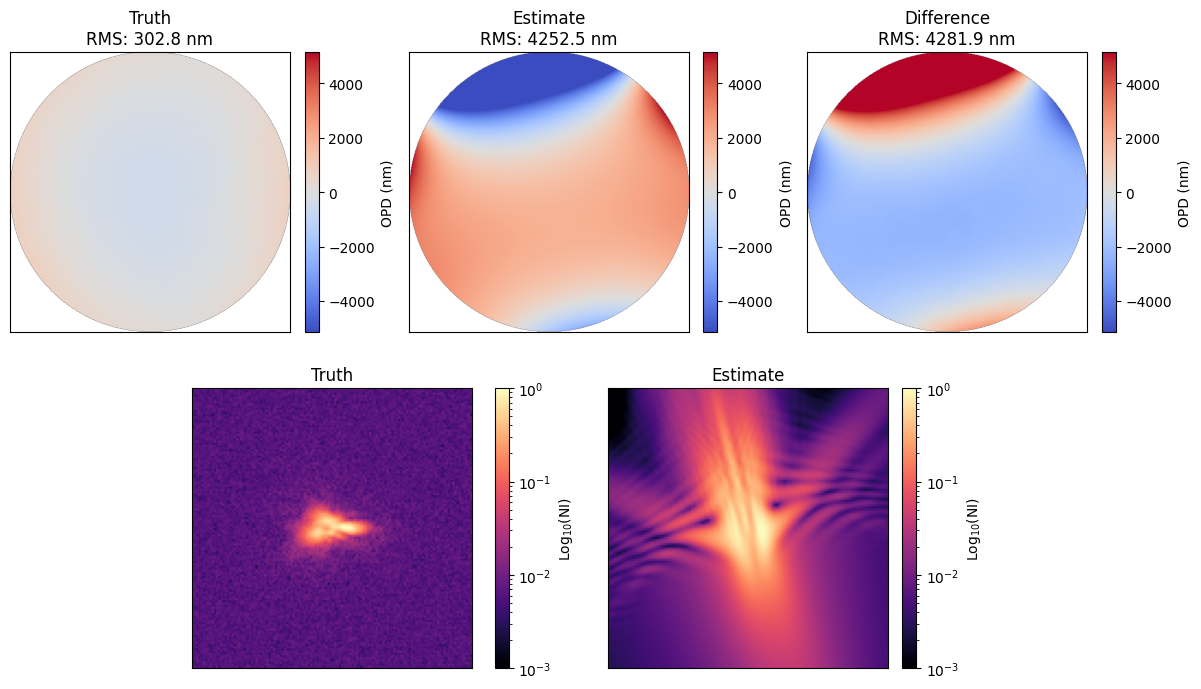

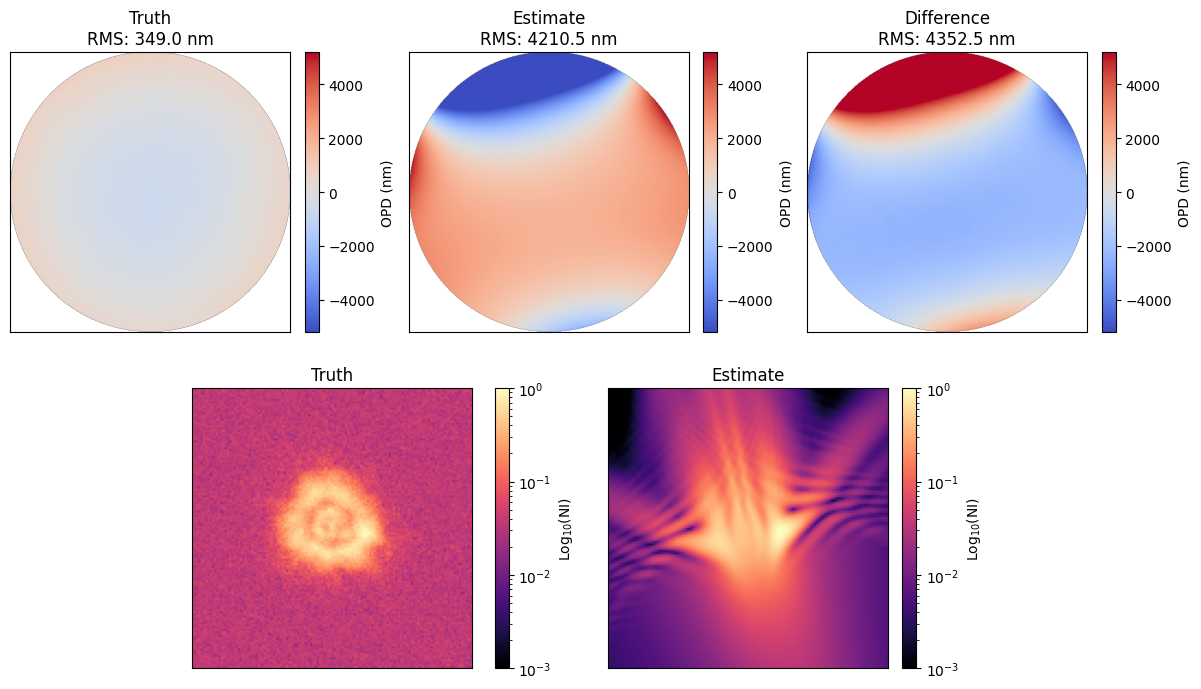

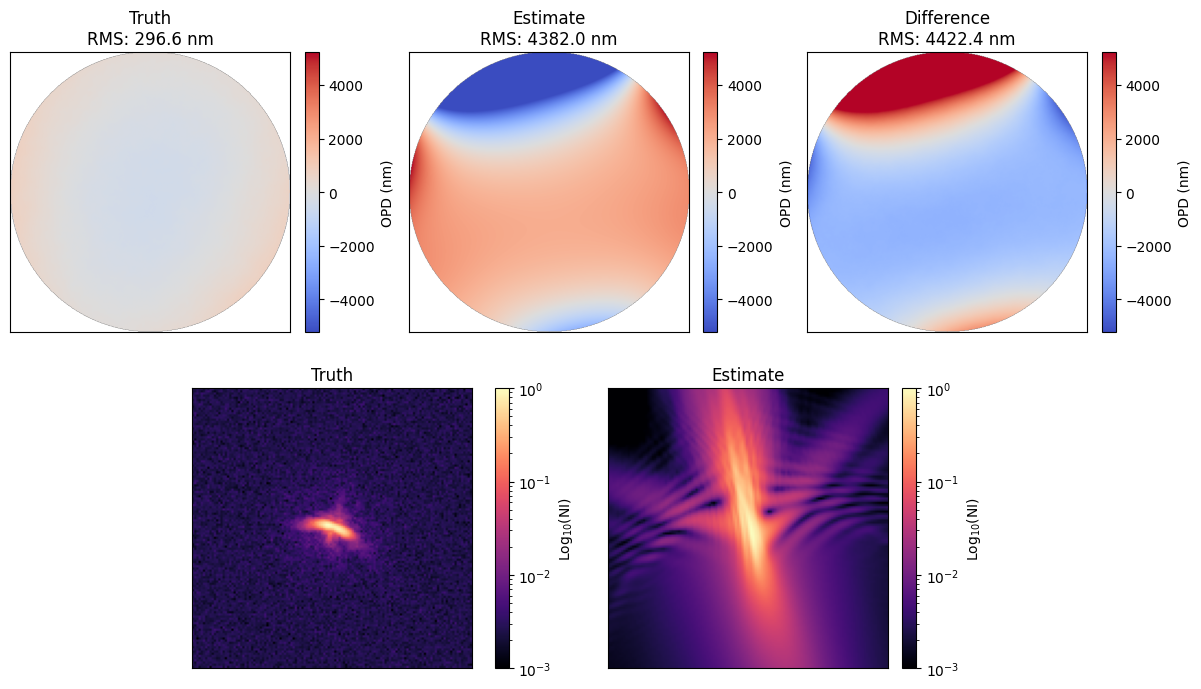

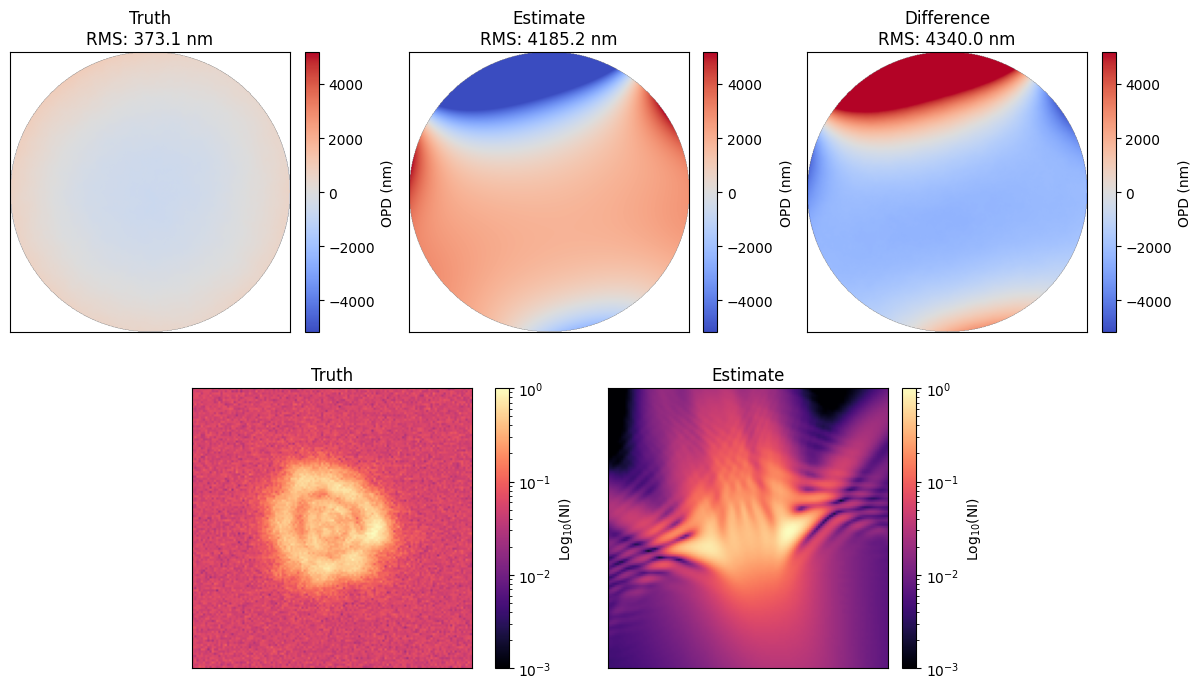

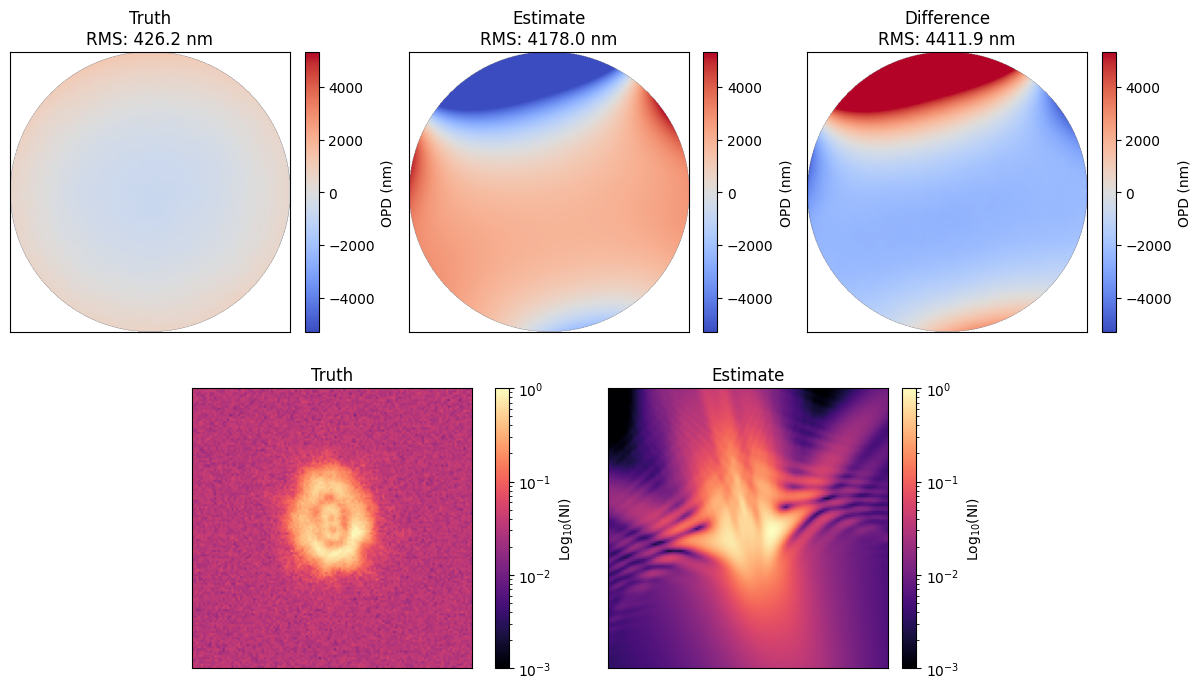

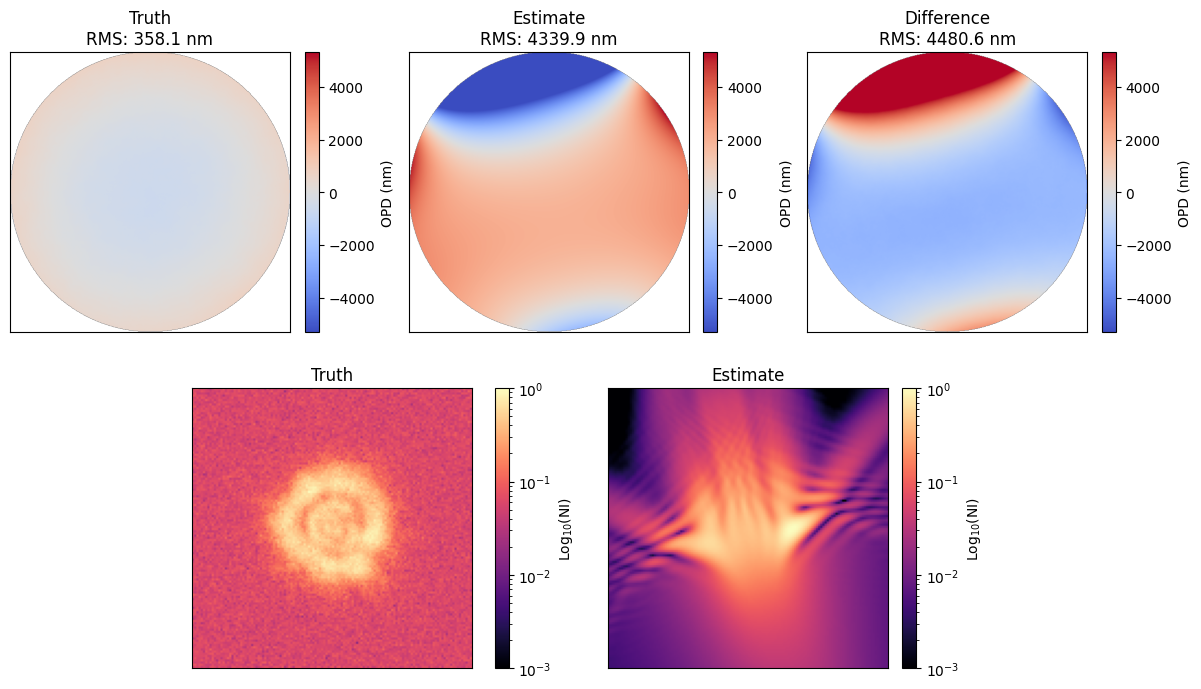

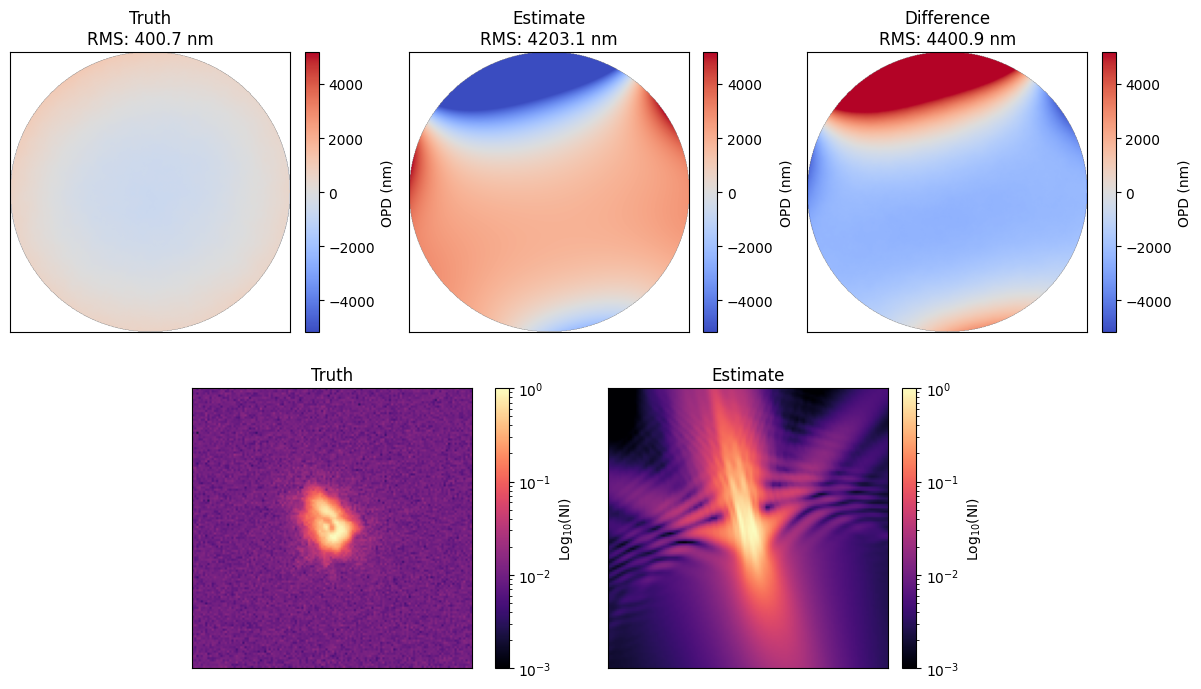

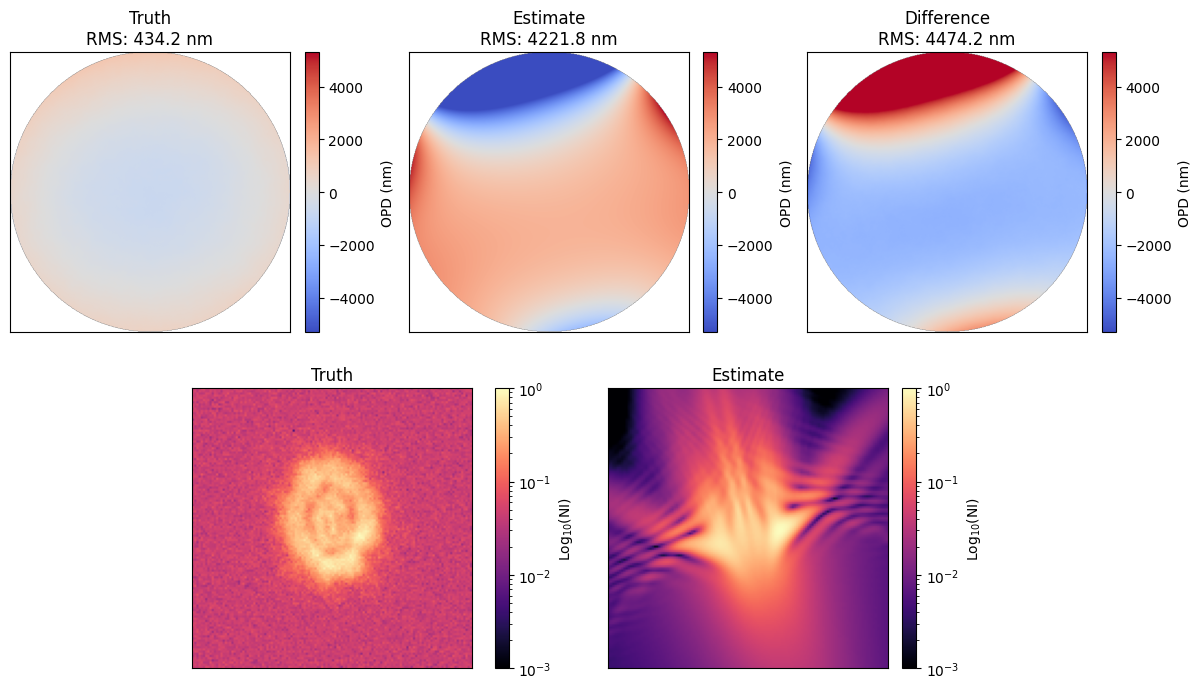

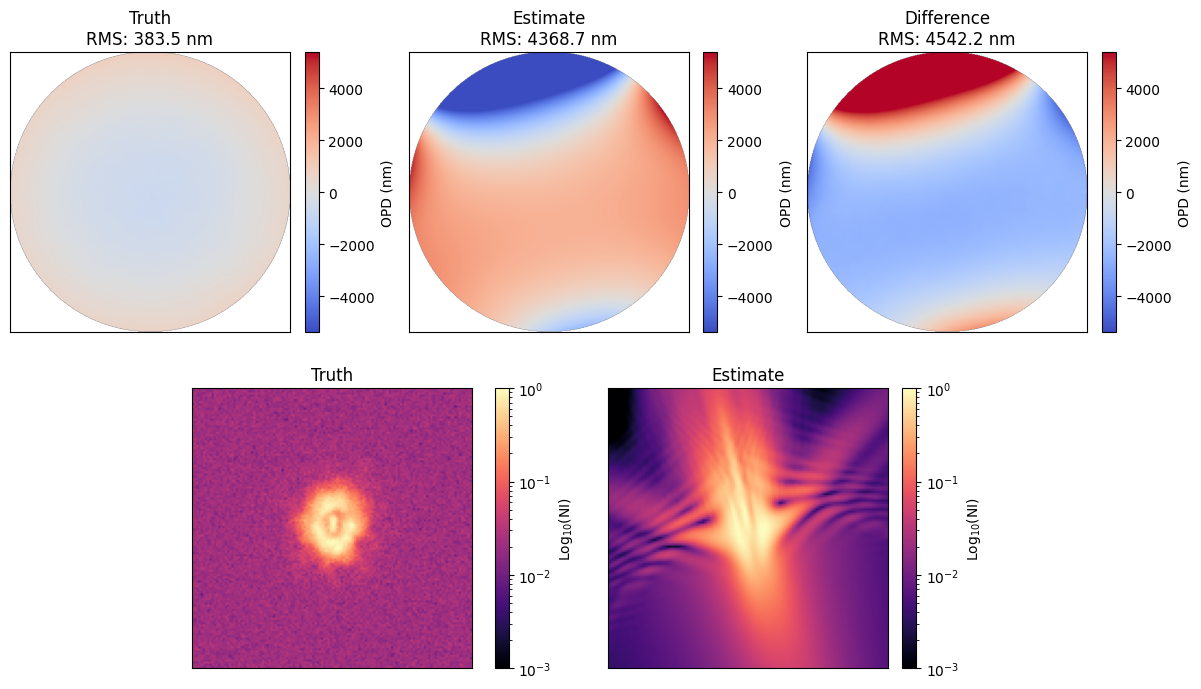

In [89]:
opds_sys = sys.get_opds()
opds_truth = [np.array(opds_sys['Optics']).sum(axis=0) + opd_field for opd_field in opds_sys['Field']]

for i, (opt, opd_truth) in enumerate(zip(ff_opt.optlist, opds_truth)):

    opd_truth[~sys.pupil] = np.nan
    opd_truth -= np.nanmean(opd_truth)

    opd_est = opt.opd
    opd_est[~sys.pupil] = np.nan
    opd_est -= np.nanmean(opd_est)

    opd_diff = opd_truth - opd_est
    opd_diff -= np.nanmean(opd_diff)

    v1 = np.nanmax(opd_truth) # np.nanstd(opd_truth) * 3
    v2 = np.nanmax(opd_est) # np.nanstd(opd_est) * 3
    v3 = np.max(np.array([v1, v2]))

    psf_truth = opt.psf
    psf_est = opt.I

    fig = plt.figure(figsize=(15, 8))
    spec = plt.GridSpec(ncols=6, nrows=2)

    ax1 = fig.add_subplot(spec[0, :2])
    map = ax1.imshow(opd_truth.get() * sys.pupil.get(), vmin=-v3, vmax=v3, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax1.set_title(f"Truth\nRMS: {np.sqrt(np.mean(opd_truth[sys.pupil.astype(bool)] ** 2)):0.1f} nm")
    ax1.set_xticks([]); ax1.set_yticks([])

    ax2 = fig.add_subplot(spec[0, 2:4])
    map = ax2.imshow(opd_est.get() * sys.pupil.get(), vmin=-v3, vmax=v3, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax2.set_title(f"Estimate\nRMS: {np.sqrt(np.mean(opd_est[sys.pupil.astype(bool)] ** 2)):0.1f} nm")
    ax2.set_xticks([]); ax2.set_yticks([])

    ax3 = fig.add_subplot(spec[0, 4:])
    map = ax3.imshow(opd_diff.get() * sys.pupil.get(), vmin=-v3, vmax=v3, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax3.set_title(f"Difference\nRMS: {np.sqrt(np.mean(opd_diff[sys.pupil.astype(bool)] ** 2)):0.1f} nm")
    ax3.set_xticks([]); ax3.set_yticks([])

    ax4 = fig.add_subplot(spec[1, :3])
    map = ax4.imshow(psf_truth.get() / psf_truth.max().get(), norm='log', vmin=1e-3, cmap='magma')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label='Log$_{10}$(NI)')
    ax4.set_title('Truth')
    ax4.set_xticks([]); ax4.set_yticks([])

    ax5 = fig.add_subplot(spec[1, 3:5])
    map = ax5.imshow(psf_est.get() / psf_est.max().get(), norm='log', vmin=1e-3, cmap='magma')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label='Log$_{10}$(NI)')
    ax5.set_title('Estimate')
    ax5.set_xticks([]); ax5.set_yticks([])